# Practical AI CA1

In this notebook I will connect to a database and ETL data to a HDF5 file. Subsequently I will connect to the HDF5 file to perform data analysis.

In [1]:
import dask
from dask.delayed import delayed
import pandas as pd
import sqlalchemy as sal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

## ETL Pipeline

Here I will connect to my SQL Server, extract data, perform preprocessing and save it to a HDF5 file for easy access later.

In [2]:
query_sensor = "SELECT * FROM sensor"
query_safety = "SELECT * FROM safety_status"
query_driver = "SELECT * FROM drivers"

label_encoder = LabelEncoder()

engine = sal.create_engine(
    "mssql+pyodbc://DESKTOP-V0N62F3\SQLEXPRESS/cab_data?driver=ODBC+Driver+17+for+SQL+Server"
)

In [3]:
@delayed
def read_sql(query, connection):
    # Read SQL query from the database.
    print(f"Reading SQL query: {query}")
    result = pd.read_sql(query, connection)
    print(f"Query execution complete: {query}")
    return result


@delayed
def read_sensors(query, connection):
    # Read sensor data from the database.
    print(f"Reading SQL query for sensors: {query}")
    result = pd.read_sql(query, connection, chunksize=100000)
    result = pd.concat([chunk for chunk in result])
    print(f"Sensor data retrieval complete: {query}")
    return result


@delayed
def preprocess_drop_outliers(new_sensors):
    # Preprocess sensor data by dropping NaN values and outliers.
    print("Dropping NaN and Outliers...")
    new_sensors = new_sensors.dropna(subset=["sec"])
    new_sensors = new_sensors[new_sensors["sec"] < 100000]

    average_sec = new_sensors.groupby("bookingID")["sec"].mean()
    average_sec = average_sec[average_sec < 2500]
    new_sensors = new_sensors[new_sensors["bookingID"].isin(average_sec.index)]

    average_accuracy = new_sensors.groupby("bookingID")["accuracy"].mean()
    average_accuracy = average_accuracy[average_accuracy < 60]
    new_sensors = new_sensors[new_sensors["bookingID"].isin(average_accuracy.index)]

    new_sensors["speed"] = new_sensors["speed"].where(new_sensors["speed"] > 0, 0)
    new_sensors["speed"] = new_sensors["speed"].where(new_sensors["speed"] < 200, 200)

    new_sensors = new_sensors.query("0 < speed < 200")

    new_sensors["speed"] = new_sensors["speed"] * 3.6

    return new_sensors


@delayed
def preprocess_interpolation(new_sensors):
    # Interpolate missing values in sensor data.
    print("Interpolating sensor data...")
    new_sensors = new_sensors.sort_values(by=["bookingID", "sec"])
    columns_to_interpolate = [
        "accuracy",
        "bearing",
        "acc_x",
        "acc_y",
        "acc_z",
        "gyro_x",
        "gyro_y",
        "gyro_Z",
        "speed",
    ]
    new_sensors[columns_to_interpolate] = new_sensors.groupby("bookingID")[
        columns_to_interpolate
    ].transform(
        lambda group: group.interpolate(method="linear", limit_direction="both")
    )

    return new_sensors


@delayed
def preprocess_create_columns(new_sensors):
    # Create new columns in sensor data.
    print("Creating new columns in sensor data...")
    new_sensors["hours"] = (new_sensors["sec"] / 3600).round(2)
    new_sensors["total_acceleration"] = (
        new_sensors["acc_x"] ** 2
        + new_sensors["acc_y"] ** 2
        + new_sensors["acc_z"] ** 2
    ) ** 0.5
    column_types = {
        "sensor_id": np.int32,
        "hours": np.int32,
    }
    new_sensors = new_sensors.astype(column_types)
    return new_sensors


@delayed
def preprocess_driver_name(drivers):
    # Preprocess driver names.
    print("Preprocessing driver names...")
    drivers["driver_name"] = drivers["driver_name"].astype(str)
    return drivers


@delayed
def preprocess_label_encoding(drivers):
    # Perform label encoding on driver information.
    print("Label encoding driver information...")
    drivers["gender"] = label_encoder.fit_transform(drivers["gender"])
    drivers["car_brand"] = label_encoder.fit_transform(drivers["car_brand"])
    return drivers


@delayed
def preprocess_age(drivers):
    # Calculate driver age.
    print("Calculating driver age...")
    drivers["date_of_birth"] = pd.to_datetime(drivers["date_of_birth"])
    current_date = datetime.now()
    drivers["age"] = (
        ((current_date - drivers["date_of_birth"]).astype("<m8[Y]")).round().astype(int)
    )
    column_types = {
        "age": np.int8,
        "car_brand": np.int8,
        "car_model_year": np.int16,
        "gender": bool,
        "driver_rating": np.float32,
        "no_of_years_driving_exp": np.int8,
    }
    drivers = drivers.astype(column_types)
    return drivers.drop("date_of_birth", axis=1)


@delayed
def preprocess_safety(joined_df):
    # Convert data types of columns in the joined DataFrame.
    print("Converting safety data type...")
    column_types = {"label": bool}
    joined_df = joined_df.astype(column_types)
    return joined_df


@delayed
def save_to_hdf(delayed_drivers, delayed_sensors, delayed_safety):
    # Join DataFrames and save to HDF5 format.
    print("Joining DataFrames and saving to HDF5...")
    delayed_drivers.to_hdf("./Data/drivers.h5", key="data", mode="w")
    delayed_sensors.to_hdf("./Data/sensors.h5", key="data", mode="w")
    delayed_safety.to_hdf("./Data/safety.h5", key="data", mode="w")

    delayed_drivers.to_csv("./Data/drivers.csv")
    delayed_sensors.to_csv("./Data/sensors.csv")
    delayed_safety.to_csv("./Data/safety.csv")
    print("Data saved to HDF5 successfully!")
    return "lol"

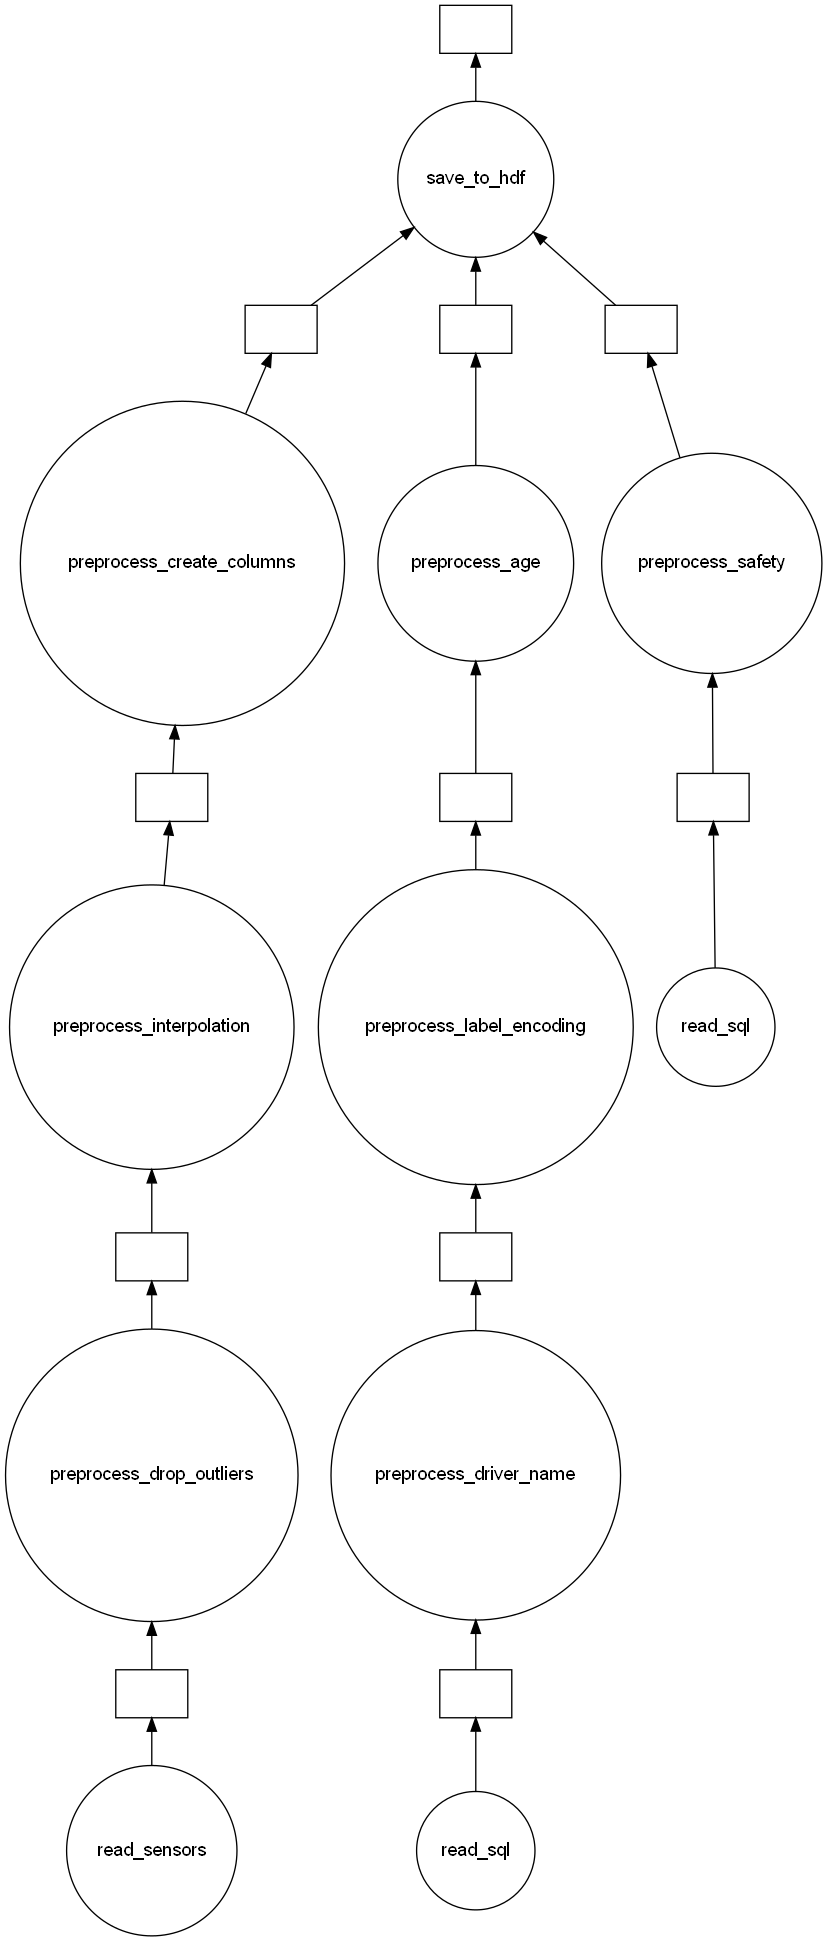

In [4]:
# Read SQL queries
delayed_sensors = read_sensors(query_sensor, engine)
delayed_drivers = read_sql(query_driver, engine)
delayed_safety = read_sql(query_safety, engine)

# Preprocess Sensors
delayed_sensors = preprocess_drop_outliers(delayed_sensors)
delayed_sensors = preprocess_interpolation(delayed_sensors)
delayed_sensors = preprocess_create_columns(delayed_sensors)

# Preprocess Drivers
delayed_drivers = preprocess_driver_name(delayed_drivers)
delayed_drivers = preprocess_label_encoding(delayed_drivers)
delayed_drivers = preprocess_age(delayed_drivers)

# Preprocess Safety
delayed_safety = preprocess_safety(delayed_safety)

final_df = save_to_hdf(delayed_drivers, delayed_sensors, delayed_safety)
# Visualize the graph
dask.visualize(
    final_df, delayed_sensors, delayed_drivers, delayed_safety, optimize_graph=True
)

In [5]:
final_df.compute(scheduler="threads")

Reading SQL query for sensors: SELECT * FROM sensor
Reading SQL query: SELECT * FROM drivers
Reading SQL query: SELECT * FROM safety_status
Query execution complete: SELECT * FROM drivers
Preprocessing driver names...
Label encoding driver information...
Calculating driver age...
Query execution complete: SELECT * FROM safety_status
Converting safety data type...
Sensor data retrieval complete: SELECT * FROM sensor
Dropping NaN and Outliers...


C:\Users\justf\AppData\Local\Temp\ipykernel_22484\2475633341.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_sensors["speed"] = new_sensors["speed"] * 3.6


Interpolating sensor data...
Creating new columns in sensor data...
Joining DataFrames and saving to HDF5...
Data saved to HDF5 successfully!


'lol'

# Exploratory Data Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

drivers = pd.read_hdf("./Data/drivers.h5")
sensors = pd.read_hdf("./Data/sensors.h5")
safety = pd.read_hdf("./Data/safety.h5")

car_brands = {
    0: "Audi",
    1: "BMW",
    2: "Honda",
    3: "Hyundai",
    4: "Kia",
    5: "Lexus",
    6: "Mazda",
    7: "Mercedes-Benz",
    8: "Mitsubishi",
    9: "Nissan",
    10: "Toyota",
    11: "Volkswagen",
}

drivers["gender"] = drivers["gender"].replace(True, "Male").replace(False, "Female")
drivers["car_brand"] = drivers["car_brand"].replace(car_brands)

### Drivers Analysis

In [2]:
drivers.head()

,driver_id,driver_name,no_of_years_driving_exp,gender,car_brand,car_model_year,driver_rating,age
0,1,Sinclair Birmingham,10,True,0,2010,3.8,41
1,2,Juline Faulks,14,False,1,2000,2.8,46
2,3,Germayne Stit,13,True,7,1999,3.8,47
3,4,Athena Coudray,16,False,5,2009,2.2,41
4,5,Batholomew Hiscoke,20,True,1,2012,2.7,45


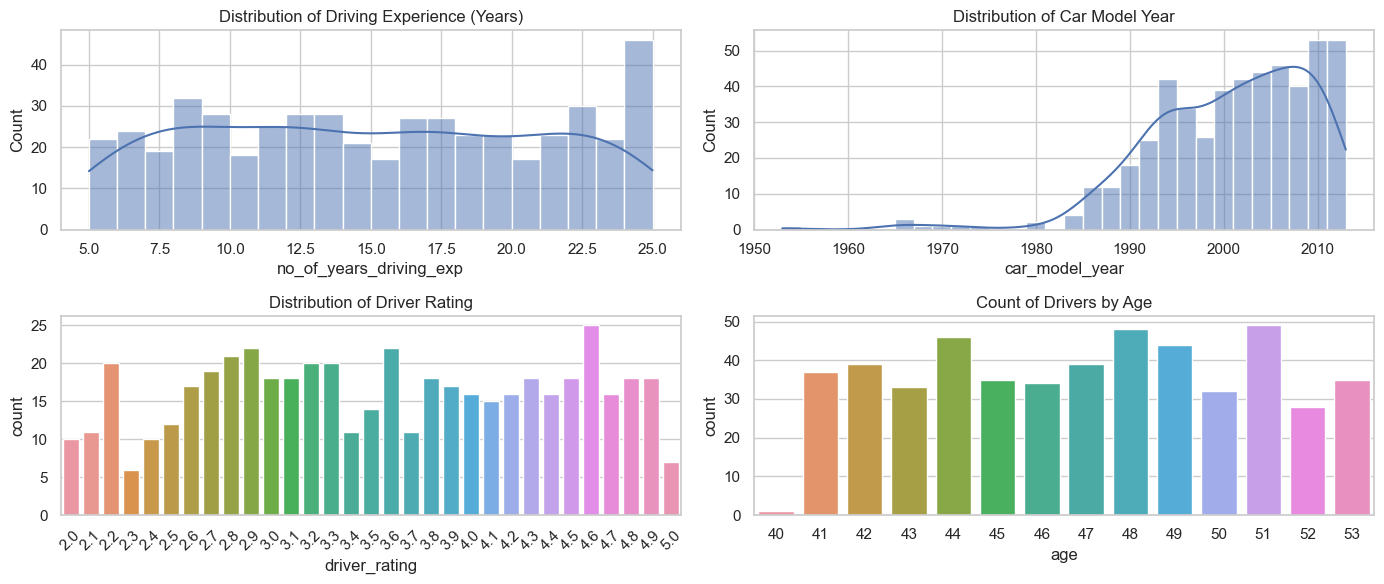

In [13]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))

sns.histplot(
    drivers["no_of_years_driving_exp"], ax=axes[0, 0], kde=True, bins=20
).set_title("Distribution of Driving Experience (Years)")

sns.histplot(drivers["car_model_year"], ax=axes[0, 1], kde=True, bins=30).set_title(
    "Distribution of Car Model Year"
)
sns.countplot(data=drivers, x="driver_rating", ax=axes[1, 0]).set_title(
    "Distribution of Driver Rating"
)
axes[1, 0].set_xticklabels(sorted(drivers["driver_rating"].unique()), rotation=45)

sns.countplot(data=drivers, x="age", ax=axes[1, 1]).set_title("Count of Drivers by Age")


plt.tight_layout()
plt.show()

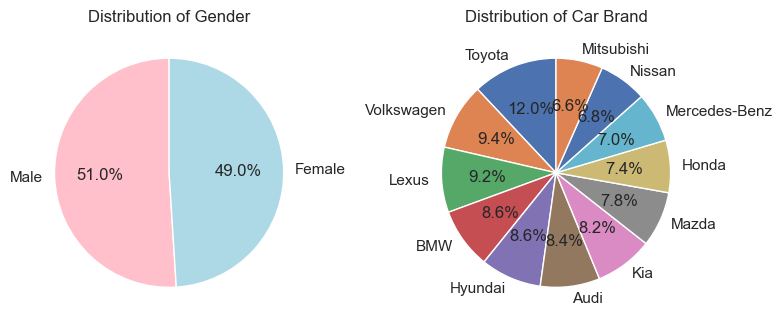

In [14]:
gender_counts = drivers["gender"].value_counts()



car_brand_counts = drivers["car_brand"].value_counts()



fig, axes = plt.subplots(1, 2, figsize=(8, 4))



axes[0].pie(
    gender_counts,
    labels=gender_counts.index,

    autopct="%1.1f%%",
    startangle=90,
    colors=["pink", "lightblue"],
)



axes[0].set_title("Distribution of Gender")

axes[1].pie(

    car_brand_counts, labels=car_brand_counts.index, autopct="%1.1f%%", startangle=90
)



axes[1].set_title("Distribution of Car Brand")



plt.tight_layout()



plt.show()

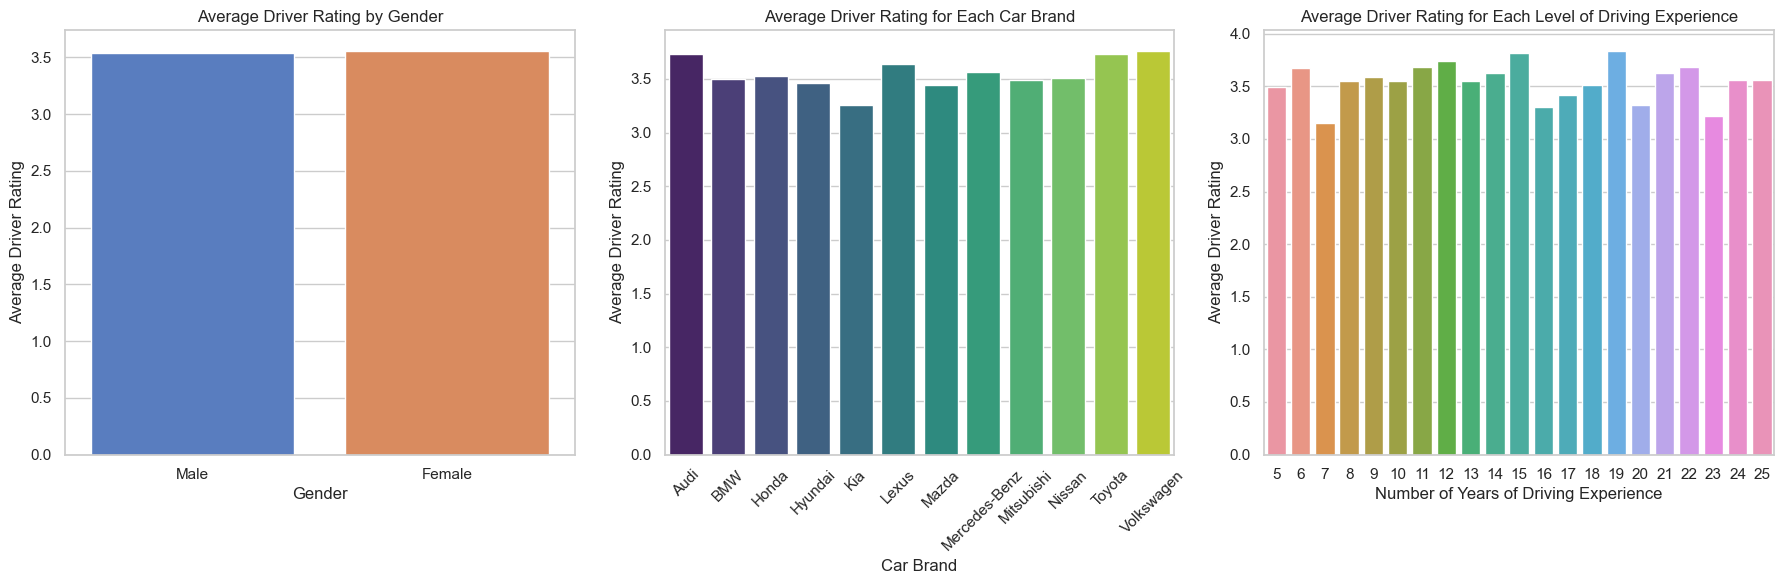

In [19]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(
    x="gender",
    y="driver_rating",
    data=drivers,
    errorbar=None,
    palette="muted",
    ax=axes[0],
)
axes[0].set_title("Average Driver Rating by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Average Driver Rating")

sns.barplot(
    x="car_brand",
    y="driver_rating",
    data=drivers,
    errorbar=None,
    palette="viridis",
    ax=axes[1],
)
axes[1].set_title("Average Driver Rating for Each Car Brand")
axes[1].set_xlabel("Car Brand")
axes[1].set_ylabel("Average Driver Rating")

sns.barplot(
    x="no_of_years_driving_exp",
    y="driver_rating",
    data=drivers,
    errorbar=None,
    ax=axes[2],
)
axes[2].set_title("Average Driver Rating for Each Level of Driving Experience")
axes[2].set_xlabel("Number of Years of Driving Experience")
axes[2].set_ylabel("Average Driver Rating")

axes[1].set_xticklabels(sorted(drivers["car_brand"].unique()), rotation=45)

plt.tight_layout()
plt.show()

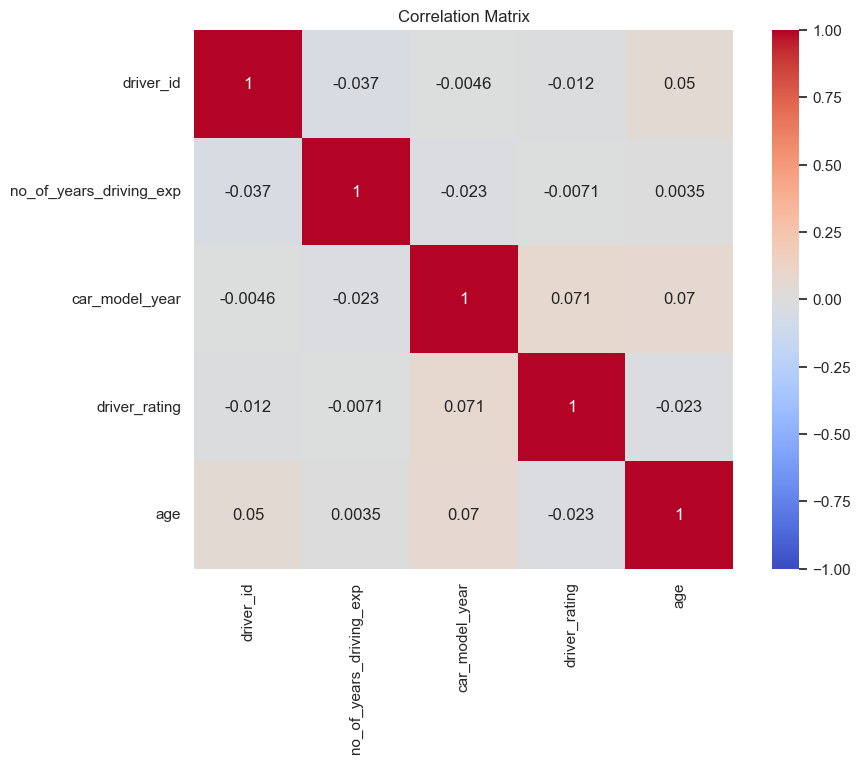

In [20]:
# Compute the correlation matrix for numerical columns
correlation_matrix = drivers.corr(numeric_only=True)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True
)
plt.title("Correlation Matrix")
plt.show()

### Safety Labels Analysis

In [21]:
safety.head()

,bookingID,driver_id,label
0,0,359,False
1,1,313,True
2,2,27,True
3,4,164,True
4,6,118,False


Number of drivers: 500
Number of bookings: 20000


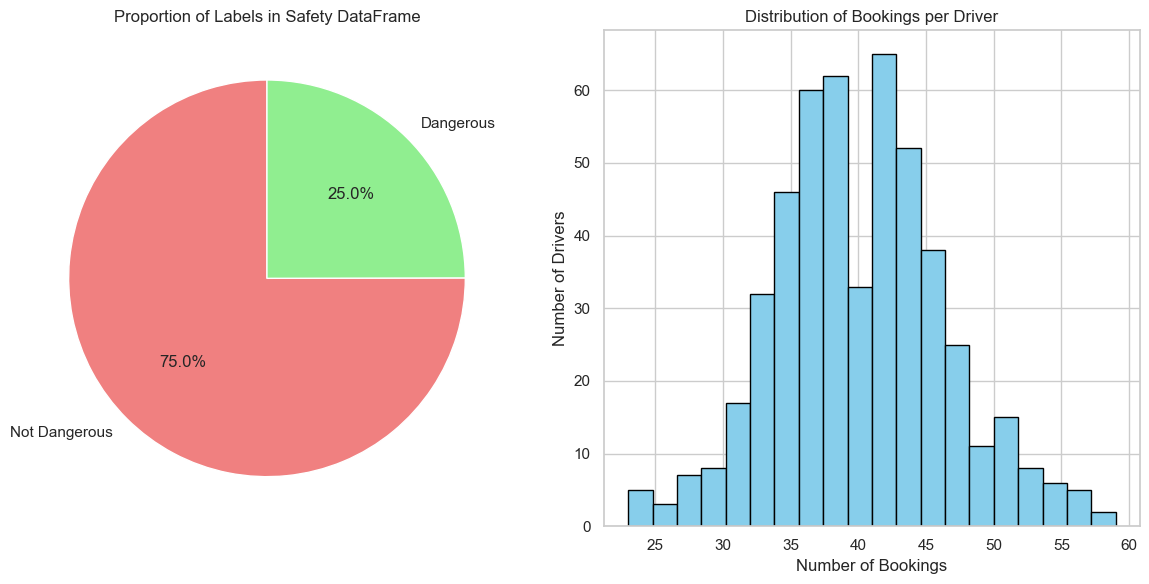

In [22]:
num_drivers = safety["driver_id"].nunique()
num_bookings = safety["bookingID"].nunique()
print(f"Number of drivers: {num_drivers}")
print(f"Number of bookings: {num_bookings}")

label_counts = safety["label"].value_counts()
label_counts.index = ["Not Dangerous", "Dangerous"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    label_counts,
    labels=label_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightcoral", "lightgreen"],
)
axes[0].set_title("Proportion of Labels in Safety DataFrame")

bookings_per_driver = safety["driver_id"].value_counts()
axes[1].hist(bookings_per_driver, bins=20, color="skyblue", edgecolor="black")
axes[1].set_title("Distribution of Bookings per Driver")
axes[1].set_xlabel("Number of Bookings")
axes[1].set_ylabel("Number of Drivers")

plt.tight_layout()
plt.show()

### Sensors Data Analysis

In [23]:
sensors.head()

,sensor_id,bookingID,accuracy,bearing,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_Z,sec,speed,hours,total_acceleration
36147,436148,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.822436,0,9.830320
86265,5786266,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.822436,0,9.614707
76045,4176046,0,8.0,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.822436,0,9.713747
28580,4528581,0,8.0,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.822436,0,10.022063
67642,6567643,0,8.0,143.298294,-1.801163,-9.195575,-2.049692,-0.006626,0.131032,-0.082647,14.0,0.822436,0,9.591873


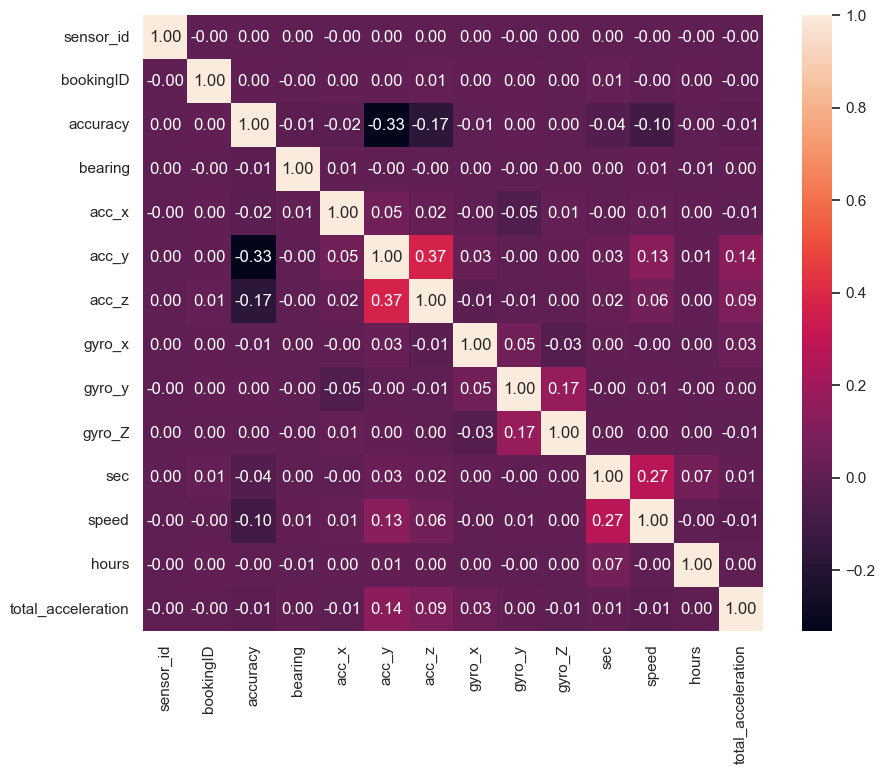

In [24]:
correlation_matrix = sensors.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [25]:
sensors.describe()

,sensor_id,bookingID,accuracy,bearing,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_Z,sec,speed,hours,total_acceleration
count,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06,5.791427e+06
mean,3.728443e+06,8.180351e+11,7.048112e+00,1.794978e+02,6.141293e-02,3.936565e+00,8.148319e-01,-2.165801e-03,8.225132e-04,-1.787913e-04,6.148244e+02,3.993865e+01,9.272326e-05,9.912392e+00
std,2.155713e+06,4.949739e+11,7.012314e+00,1.015301e+02,1.441991e+00,8.439353e+00,3.268663e+00,1.408251e-01,3.337907e-01,1.435025e-01,4.479928e+02,2.726012e+01,9.628846e-03,1.376554e+00
min,2.000000e+00,0.000000e+00,7.500000e-01,0.000000e+00,-3.898399e+01,-5.780019e+01,-6.356081e+01,-2.644802e+01,-5.515758e+01,-3.746538e+01,0.000000e+00,2.316289e-25,0.000000e+00,5.074228e-03
25%,1.861959e+06,3.779571e+11,3.900000e+00,9.200000e+01,-5.592651e-01,-8.070764e+00,-1.056213e+00,-3.240977e-02,-3.726278e-02,-2.239894e-02,2.570000e+02,1.541923e+01,0.000000e+00,9.503926e+00
50%,3.721294e+06,7.988639e+11,4.818000e+00,1.790000e+02,5.188904e-02,8.947405e+00,6.997070e-01,-1.282845e-03,8.544922e-04,-7.629395e-05,5.430000e+02,3.763842e+01,0.000000e+00,9.829694e+00
75%,5.593958e+06,1.245541e+12,8.000000e+00,2.680000e+02,6.751258e-01,9.700241e+00,2.693559e+00,2.832031e-02,3.944479e-02,2.206349e-02,8.840000e+02,6.158027e+01,0.000000e+00,1.020560e+01
max,7.469656e+06,1.709397e+12,4.261350e+02,3.599995e+02,6.687346e+01,6.115936e+01,7.805576e+01,1.830983e+01,8.031496e+01,4.505986e+01,4.064000e+03,3.169341e+02,1.000000e+00,8.852724e+01


In [26]:
print(f"Max trip duration: {sensors['hours'].max()} hours")
print(f"Max trip speed: {round(sensors['speed'].max(),3)} m/s")
print(f"Max trip acceleration: {round(sensors['total_acceleration'].max(),3)} m/s^2")

Max trip duration: 1 hours
Max trip speed: 316.934 m/s
Max trip acceleration: 88.527 m/s^2


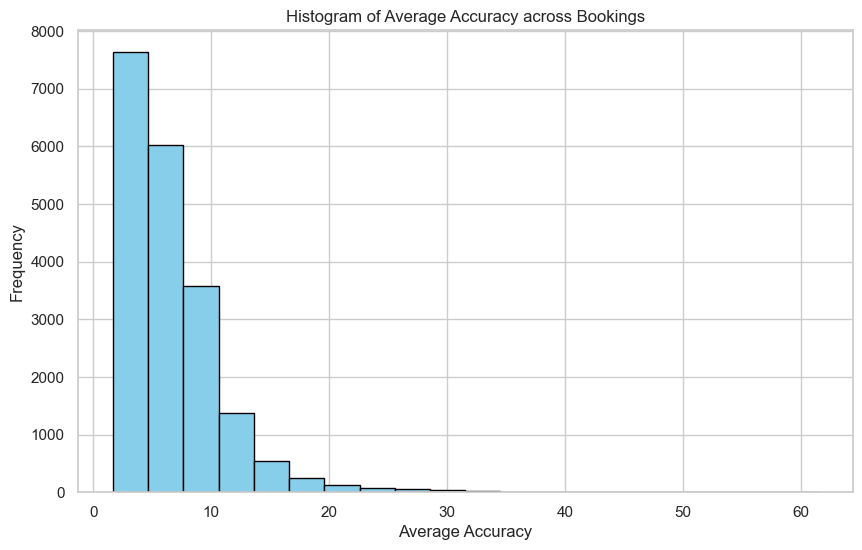

In [27]:
plt.figure(figsize=(10, 6))
average_accuracy = sensors.groupby("bookingID")["accuracy"].mean()
plt.hist(average_accuracy, bins=20, color="skyblue", edgecolor="black")
plt.title("Histogram of Average Accuracy across Bookings")
plt.xlabel("Average Accuracy")
plt.ylabel("Frequency")
plt.show()

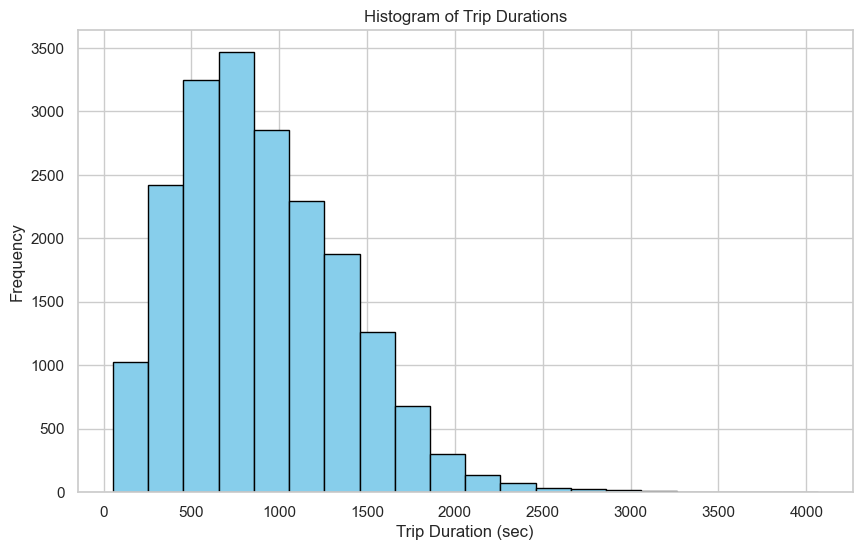

In [28]:
plt.figure(figsize=(10, 6))
total_sec = sensors.groupby("bookingID")["sec"].max()
plt.hist(total_sec, bins=20, color="skyblue", edgecolor="black")
plt.title("Histogram of Trip Durations")
plt.xlabel("Trip Duration (sec)")
plt.ylabel("Frequency")
plt.show()